In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# 1. Intro & Setup

This work is focused on tackling the "AI or Not" Hugging Face competition (https://huggingface.co/spaces/competitions/aiornot).


The task consists in building a model that can identify AI generated images.

In particular this implementation compares two different pretrained backbones fine-tuned on this task:
- ResNet-50
- ConvNeXt-T (from the paper "A ConvNet for the 2020s")

This project has the following folder structure

```
- res                   | Different resources like the images, model weights, ...
- src            
| - dataset.py          | Functions for handling the dataset, dataloaders and data transformations
| - utils.py            | Utility functions like image plots and setting the determinism
| - model.py            | Functions for getting the pretrained models and variables used in training
| - train.py            | Training and evaluation loops
```

In [2]:
# Imports

import os
import shutil

import pandas as pd
import torch
from torchvision import datasets, transforms as T

from src.dataset import (
    LABELS_INT2TEXT,
    create_dataloaders,
    create_datasets,
    create_transforms,
    split_dataframe, 
    ImageDataset
)
from src.utils import plot_images, set_seed, get_mean_and_std
from src.model import get_model, create_accessories, load_model
from src.train import train_model, eval_loop


In [3]:
# Constants definition

random_seed = 97
num_classes = len(LABELS_INT2TEXT)

res_path = "res"
images_path = os.path.join(res_path, "images")
raw_csv_path = os.path.join(res_path, "raw_images.csv")
csv_path = os.path.join(res_path, "images.csv")
models_path = os.path.join(res_path, "models")
dataset_paths = {
    "train": os.path.join(res_path, "dataset", "train"),
    "valid": os.path.join(res_path, "dataset", "valid"),
    "test": os.path.join(res_path, "dataset", "test"),
}
test_size = 0.1
validation_size = 0.1

input_size = 224
train_batch_size = 64
eval_batch_size = 128
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

set_seed(random_seed)

# 2. Data Exploration

The competition provides a CSV file containing all the images provided and their respecitve label 
- 0: "Real"
- 1: AI Generated or "Fake"

In [4]:
df = pd.read_csv(raw_csv_path)

df.head()

,id,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,0
4,4.jpg,1


In [5]:
df["original_file_path"] = df.apply(lambda x: os.path.join(images_path, x["id"]), axis=1)

df.head()

,id,label,original_file_path
0,0.jpg,1,res/images/0.jpg
1,1.jpg,1,res/images/1.jpg
2,2.jpg,1,res/images/2.jpg
3,3.jpg,0,res/images/3.jpg
4,4.jpg,1,res/images/4.jpg


In [6]:
df.value_counts("label")

label
1    10330
0     8288
dtype: int64

The dataset contains `10330` real images and `8288` AI generated ones, presenting a slight imbalance in the classes.

## 2.1. Observing Samples

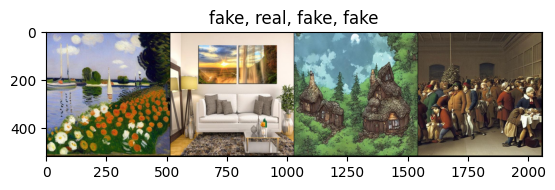

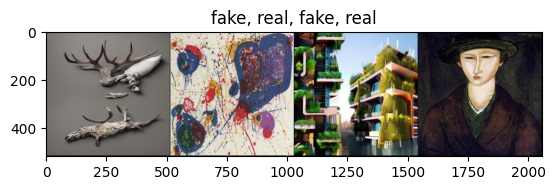

In [7]:
# Plotting some random images, the title in the plot depics the label of the respective 
# picture, going from left to right with `fake` being the label of images which are 
# AI generated and `real` images which are not

for i in range(2):
    df_subset = df.sample(4)
    paths = [img["file_path"] if "file_path" in img and os.path.exists(img["file_path"]) else img["original_file_path"] for idx, img in df_subset.iterrows()]
    plot_images(
        paths, 
        labels=df_subset["label"]
    )

By taking a look at random sampled images, it's easy to notice that the task isn't always straightfoward even from a human perspective.

Many AI generated images present generally weird artifacts, especially when depicting humans.

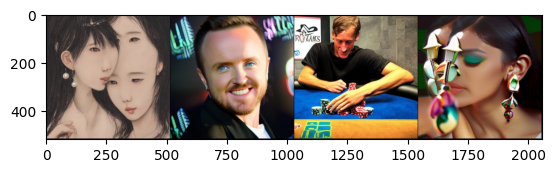

In [11]:
plot_images(list(df.loc[df["id"].isin([f"{idx}.jpg" for idx in [10539, 2697, 15790, 17950]]), "original_file_path"]))

Other AI generated ones are pretty realistic and don't present weird patterns at all:

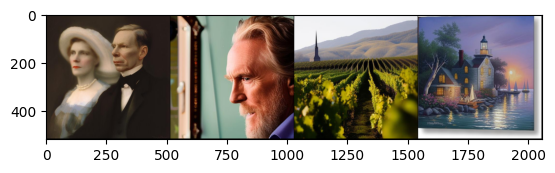

In [13]:
plot_images(list(df.loc[df["id"].isin([f"{idx}.jpg" for idx in [5534, 9975, 12137, 16873]]), "original_file_path"]))

While, at the same time, the following images are not AI generated, but depict some abstract art or low resolution pictures, making them difficult to interpret correctly.

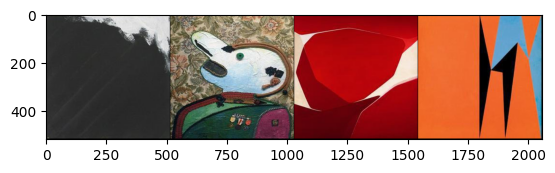

In [14]:
plot_images(list(df.loc[df["id"].isin([f"{idx}.jpg" for idx in [317, 451, 941, 18412]]), "original_file_path"]))

## 2.2. Train / Test Split

The dataset is split in three different groups:
- Training set (80%)
- Validation set (10%)
- Test set (10%)

An holdout test set is being kept outside of the whole train/eval loop in order to perform the final evaluations without doing any reasoning about the models on it.

The sampling is stratified in order to keep the labels ratio the same in every split.

In [15]:
if "split" not in df:
    # Performs the split into the three different subsets
    dfs = split_dataframe(df, validation_size=validation_size, test_size=test_size, seed=random_seed)

    for key, df_split in dfs.items():
        # Assigns the right split ID to the original DataFrame
        df.loc[df["id"].isin(df_split["id"]), "split"] = key

        # Creates the folders that are going to contain the images
        for class_label in LABELS_INT2TEXT.values():
            class_folder = os.path.join(dataset_paths[key], class_label)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)

    # Update the path for each image in order to store them in the {split}/{label} folder
    df["file_path"] = df.apply(
        lambda x: os.path.join(dataset_paths[x["split"]], LABELS_INT2TEXT[x["label"]], x["id"]), axis=1
    )

    # Save the updated CSV file
    df.to_csv(csv_path, index=False)
    
    print(df.value_counts("split"))
    
    # Move each image into the respective folder
    for idx, row in df.reset_index().iterrows():
        if os.path.exists(row["original_file_path"]):
            shutil.move(row["original_file_path"], row["file_path"])

split
train    14894
test      1862
valid     1862
dtype: int64


## 2.3. Mean and Standard Deviation

In [17]:
# Computes the mean and standard deviation of the training set to perform normalization

train_ds = ImageDataset(dataset_paths["train"], transform=T.ToTensor())
ds_mean, ds_std = get_mean_and_std(train_ds, batch_size=eval_batch_size)
ds_mean, ds_std

100%|██████████| 117/117 [00:56<00:00,  2.08it/s]


(tensor([0.4840, 0.4334, 0.3912]), tensor([0.2889, 0.2829, 0.2845]))

$\mu= (0.4840, 0.4334, 0.3912)$

$\sigma = (0.2889, 0.2829, 0.2845)$

# 3. Training

Experiments were performed by logging results to WandB

In [4]:
ds_mean = torch.tensor([0.4840, 0.4334, 0.3912])
ds_std = torch.tensor([0.2889, 0.2829, 0.2845])

transforms = create_transforms(["train", "test", "valid"], input_size, ds_mean, ds_std)
datasets = create_datasets(dataset_paths, transforms)
dataloaders = create_dataloaders(datasets, train_batch_size=train_batch_size, eval_batch_size=eval_batch_size)

## 3.1. Baseline

As starting baseline a ResNet-50 with a frozen backbone is trained with very basic hyperparameters:
- 10 epochs
- Adam optimizer
- 3e-4 learning rate
- No weight decay
- No learning rate scheduling
- Label smoothing: 0

In [11]:
model = get_model("resnet", num_classes, fine_tune=False)
model = model.to(device)

train_params = {
    "epochs": 10,
    "loss": "cross_entropy",
    "optimizer": "adam",
    "scheduler": None,
    "learning_rate": 3e-4,
    "weight_decay": 0,
    "label_smoothing": 0
}
criterion, optimizer, scheduler = create_accessories(model, train_params)

### Training

In [12]:
model, baseline_preds = train_model(
    run_name="baseline",
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    train_params=train_params,
    scheduler=scheduler,
    output_preds=True,
    device=device,
    seed=random_seed,
    save_dir=models_path
)

100%|██████████| 10/10 [02:24<00:00, 14.50s/it]

Training complete in 2m 26s
Best val Acc: 0.902793


train/accuracy,▁▅▆▆▇▇▇███
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▇▅▅▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▂▁▁
valid/accuracy,▁▄▅▆▅▇▇▇▇█
valid/epoch,▁▂▃▃▄▅▆▆▇█
valid/loss,█▅▃▂▃▁▂▂▂▁
train/accuracy,0.90647
train/epoch,10
train/learning_rate,0.0003
train/loss,0.23657


![Baseline Training Charts](res/report/baseline_train.png)
![Baseline Evaluation Charts](res/report/baseline_eval.png)

## 3.2. ResNet

Following up, after a few empirical tests ResNet-50 models were trained with the following hyperparameters:
- 50 epochs
- AdamW optimizer
- 3e-4 learning rate
- 2e-5 Weight Decay
- Cosine Annealing LR scheduling
- Label smoothing: 0

In [28]:
model = get_model("resnet", num_classes, fine_tune=True)
model = model.to(device)

train_params = {
    "epochs": 50,
    "loss": "cross_entropy",
    "optimizer": "adamw",
    "scheduler": "cosine",
    "learning_rate": 3e-4,
    "weight_decay": 2e-5,
    "label_smoothing": 0
}
criterion, optimizer, scheduler = create_accessories(model, train_params)

### Training

In [29]:
model, resnet_preds = train_model(
    run_name="resnet",
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    train_params=train_params,
    scheduler=scheduler,
    output_preds=True,
    device=device,
    seed=random_seed,
    save_dir=models_path
)

train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,▁▄▆▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆
train/epoch,0.92275
train/loss,0.69662


100%|██████████| 50/50 [31:18<00:00, 37.57s/it]

Training complete in 31m 24s
Best val Acc: 0.972073


train/accuracy,▁▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/loss,█▅▅▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/accuracy,▁▂▅▆▅▆▅▄▅▆▃▆▆▆▆▆▇▇▇▇▇██▇▇▇▇▇█▇▇▇▇▇██████
valid/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid/loss,▇█▃▂▄▂▃▅▄▂▆▂▃▃▃▃▁▁▂▁▃▁▂▃▃▂▂▂▁▂▃▂▂▃▂▂▂▂▂▂
train/accuracy,0.99799
train/epoch,50
train/loss,0.00655
valid/accuracy,0.971
valid/epoch,50


![ResNet-50 Training Charts](res/report/resnet_train.png)
![ResNet-50 Evaluation Charts](res/report/resnet_eval.png)

## 3.3. ConvNeXt

With ConvNeXt, experiment were performed with some heavier regularization as it resulted more prone to overfitting, specifically, some label smoothing were added and a higher weight decay was used.
- 50 epochs
- AdamW optimizer
- 3e-4 learning rate
- 5e-2 Weight Decay
- Cosine Annealing LR scheduling
- Label smoothing: 0.1

In [6]:
model = get_model("convnext", num_classes, fine_tune=True)
model = model.to(device)

train_params = {
    "epochs": 50,
    "loss": "cross_entropy",
    "optimizer": "adamw",
    "scheduler": "cosine",
    "learning_rate": 3e-4,
    "weight_decay": 5e-2,
    "label_smoothing": 0.01
}
criterion, optimizer, scheduler = create_accessories(model, train_params)

### Training

In [7]:
model, convnext_preds = train_model(
    run_name="convnext",
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    train_params=train_params,
    scheduler=scheduler,
    output_preds=True,
    device=device,
    seed=random_seed,
    save_dir=models_path
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: astockman. Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [1:43:29<00:00, 124.19s/it]

Training complete in 103m 31s
Best val Acc: 0.968851


train/accuracy,▁▄▄▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/loss,█▅▄▄▃▃▃▃▃▂▃▂▂▂▁▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/accuracy,▆▂▆▅▅▆▃▇▃█▃▁▇▇█▇▅▅▆▆▆▆▇▅█▆▅▇█▇▅██▇▇▇████
valid/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid/loss,▂▄▂▂▃▂▄▁▄▁▄█▂▂▁▂▄▄▃▂▃▄▂▄▂▄▅▃▂▂▅▂▁▂▃▂▂▁▂▂
train/accuracy,0.99792
train/epoch,50
train/loss,0.03673
valid/accuracy,0.96617
valid/epoch,50


![ConvNeXt-T Training Charts](res/report/convnext_train.png)
![ConvNeXt-T Evaluation Charts](res/report/convnext_eval.png)

# 4. Evaluation

In [8]:
# Compute metrics for every network in every split
stats = {}

for model_type in ["baseline", "resnet", "convnext"]:
    stats[model_type] = {}
    
    for split in ["train", "valid", "test"]:
        model = load_model(model_type, os.path.join(models_path, model_type), num_classes)
        model = model.to(device)
        
        loss, acc, preds = eval_loop(
            model=model,
            criterion=torch.nn.CrossEntropyLoss(),
            dataloader=dataloaders[split],
            output_preds=True,
            device=device,
        )

        stats[model_type][split] = {
            "loss": loss,
            "acc": acc,
            "preds": preds
        }

In [12]:
for split in stats[model_type].keys():
    for model_type in stats.keys():
        d = stats[model_type][split]
        print(f"{model_type} - Split: {split} - Loss: {d['loss']:.4} - Accuracy: {d['acc']:.4}")

baseline - Split: train - Loss: 0.224 - Accuracy: 0.9125
resnet - Split: train - Loss: 0.005674 - Accuracy: 0.9982
convnext - Split: train - Loss: 0.009793 - Accuracy: 0.9977
baseline - Split: valid - Loss: 0.2452 - Accuracy: 0.9028
resnet - Split: valid - Loss: 0.1328 - Accuracy: 0.9721
convnext - Split: valid - Loss: 0.09929 - Accuracy: 0.9689
baseline - Split: test - Loss: 0.2472 - Accuracy: 0.9039
resnet - Split: test - Loss: 0.1247 - Accuracy: 0.9678
convnext - Split: test - Loss: 0.1238 - Accuracy: 0.964


| Model      | Split  | Loss   | Accuracy |
|------------|--------|--------|----------|
| Baseline   | train  | 0.2240 | 0.9125   |
| ResNet-50  | train  | 0.0057 | 0.9982   |
| ConvNeXt-T | train  | 0.0098 | 0.9977   |
| Baseline   | valid  | 0.2452 | 0.9028   |
| ResNet-50  | valid  | 0.1328 | 0.9721   |
| ConvNeXt-T | valid  | 0.0993 | 0.9689   |
| Baseline   | test   | 0.2472 | 0.9039   |
| ResNet-50  | test   | 0.1247 | 0.9678   |
| ConvNeXt-T | test   | 0.1238 | 0.9640   |

Despite various emprirical tests, the final performances produced by ConvNeXt on the test set was worse then ResNet's, suggesting that a finer hyperparameter search should be performed in order to actually verify the potential of the different backbones.  

# 5. Conclusions

Various improvements could definetely be tried on different fronts:
- Larger models - With more time and computing power available, performances could be definetely improve by using larger and more expressive networks
- Finer hyperparameter search - Tuning the amount of regularization applied would be key to find the perfect bias/variance tradeoff
- Trying ensembling - Ensembling could surely improve the final accuracy though requiring more time for training
- Data augmentation - Most promising techniques would be CutMix, MixUp, RandErasing